<h1>LSTM AutoEncoder For Anomaly Detection</h1>

<h4>The Intuition:</h4>

in this notebook we are going to create and encoder - decoder lstm architecture model that is going to reconstruct some given vectors 
once the reconstruction error falls behing a certain threhold, we'll identify the vector as an anomaly 

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from keras.models import Sequential
from keras import metrics
import keras
import tensorflow as tf
import os
#from scikeras.wrappers import KerasRegressor
#from sklearn.model_selection import GridSearchCV
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout

In [81]:
def generate_datasets_for_training(data, window_size, test_size=0.1):
    _l = len(data)
    Xs = []
    Ys = []
    for i in range(0, _l-window_size):
        Xs.append(data[i:i+window_size].values) 
        # Convert list to numpy array
    Xs = np.array(Xs)
    
    # Calculate the split index
    split_idx = int((1 - test_size) * len(Xs))
    
    # Split the data manually without shuffling
    tr_x, ts_x = Xs[:split_idx], Xs[split_idx:]
    
    return (tr_x.shape[2], tr_x, ts_x)

In [2]:
def generate_datasets_for_training2(data, window_size):
    _l = len(data)
    Xs = []
    # while (_l % window_size != 0):
    #     _l -= 1
    # data= data.iloc[:(len(data)-_l)]
    for i in range(0, _l-window_size):
        Xs.append(data[i:i+window_size].values) 
        # Convert list to numpy array
    Xs = np.array(Xs)
    
    return (Xs.shape[2], Xs)

<h3>This function will normalize my data (taking into account the actuators and sensors difference)</h3>

In [3]:
def dataEngineering(filepath, scaler):
    #let me now split the data into sensors and actuators and the normalize the sensors
    actuators_NAMES=['MV101', 'P101','P102', 'MV201', 'P201','P202', 'P203', 'P204', 'P205', 'P206', 'MV301','MV302','MV303','MV304','P301', 'P302', 'P401','P402','P403', 'P404', 'UV401', 'P501', 'P502','P601', 'P602','P603']
    DF = pd.read_csv(filepath)
    DF.set_index('Timestamp', inplace=True)
    #REMOVING THE LAST COLUMN
    DF= DF.iloc[:, :-1]
    sensors= DF.drop(actuators_NAMES, axis=1)
    actuators= DF[actuators_NAMES]
    scaler.fit(sensors)
    # Transform the data using the scaler
    normalized_sensors = scaler.transform(sensors)
    # Convert the normalized data back to a DataFrame
    normalized_sensors = pd.DataFrame(normalized_sensors, columns=sensors.columns)
    actuators_dummies=actuators
    for actuator in actuators_NAMES:
      actuators_dummies[actuator]= pd.Categorical(actuators_dummies[actuator], categories=[0, 1, 2])
      actuators_dummies= pd.get_dummies(actuators_dummies, columns=[actuator],dtype=int)
    normalized_sensors.index=actuators_dummies.index
    allData= pd.concat([normalized_sensors, actuators_dummies], axis=1)
    return allData

In [4]:
filepath = "D://Msc_Data_Science_1//Semester 2//Data science lab 1//LSTM data//SWaT_Dataset_Normal_v0 2.csv"
scaler = MinMaxScaler()
data = dataEngineering(filepath, scaler)

C:\Users\mfaki\AppData\Local\Temp\ipykernel_26884\4273617739.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actuators_dummies[actuator]= pd.Categorical(actuators_dummies[actuator], categories=[0, 1, 2])


In [50]:
data

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,P502_2,P601_0,P601_1,P601_2,P602_0,P602_1,P602_2,P603_0,P603_1,P603_2
Timestamp,,,,,,,,,,,,,,,,,,,,,
22/12/2015 4:00:00 PM,0.899895,0.160292,0.000000,0.00000,0.019710,0.993304,0.985738,0.947643,0.220683,0.000000,...,0,0,1,0,0,1,0,0,1,0
22/12/2015 4:00:01 PM,0.895111,0.159845,0.000000,0.00000,0.019710,0.992222,0.985738,0.947317,0.220683,0.000000,...,0,0,1,0,0,1,0,0,1,0
22/12/2015 4:00:02 PM,0.888694,0.159533,0.000000,0.00000,0.019710,0.991707,0.987862,0.946828,0.220683,0.000000,...,0,0,1,0,0,1,0,0,1,0
22/12/2015 4:00:03 PM,0.884611,0.158819,0.000000,0.00000,0.019710,0.991398,0.987862,0.946828,0.220501,0.000000,...,0,0,1,0,0,1,0,0,1,0
22/12/2015 4:00:04 PM,0.883327,0.158372,0.003408,0.00000,0.019710,0.991398,0.987862,0.946828,0.220365,0.000000,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28/12/2015 9:59:55 AM,0.896278,0.457619,0.627270,0.25853,0.103740,0.981663,0.935973,0.937812,0.933191,0.999677,...,0,0,1,0,0,1,0,0,1,0
28/12/2015 9:59:56 AM,0.892078,0.457530,0.627270,0.25853,0.103740,0.981663,0.935973,0.936943,0.933282,0.999677,...,0,0,1,0,0,1,0,0,1,0
28/12/2015 9:59:57 AM,0.886944,0.457440,0.627270,0.25853,0.104221,0.982693,0.935973,0.935965,0.933372,0.999677,...,0,0,1,0,0,1,0,0,1,0


In [8]:
feats, tr_x = generate_datasets_for_training2(data,10)

In [9]:
print("the shape of train X is: ",tr_x.shape)

the shape of train X is:  (496790, 10, 103)


<h3>A function that takes a sensor and displays a line plot</h3>

In [61]:
import matplotlib.pyplot as plt

def showSensors(sensor_names, data, num_values=1000):
    """
    Plots line graphs for the specified sensors (columns) of the DataFrame.

    Parameters:
    sensor_names (list of str): The names of the columns to plot.
    data (pd.DataFrame): The DataFrame containing the data.
    num_values (int): The number of values to display in the plot.

    Returns:
    None
    """
    # Ensure that all sensor names exist in the DataFrame
    for sensorname in sensor_names:
        if sensorname not in data.columns:
            raise ValueError(f"Column '{sensorname}' not found in the DataFrame")
    
    plt.figure(figsize=(10, 6))

    # Plot each sensor
    for sensorname in sensor_names:
        plt.plot(data[sensorname].iloc[:num_values], label=sensorname)
    
    plt.title(f"Line Graph for {', '.join(sensor_names)} (first {num_values} values)")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


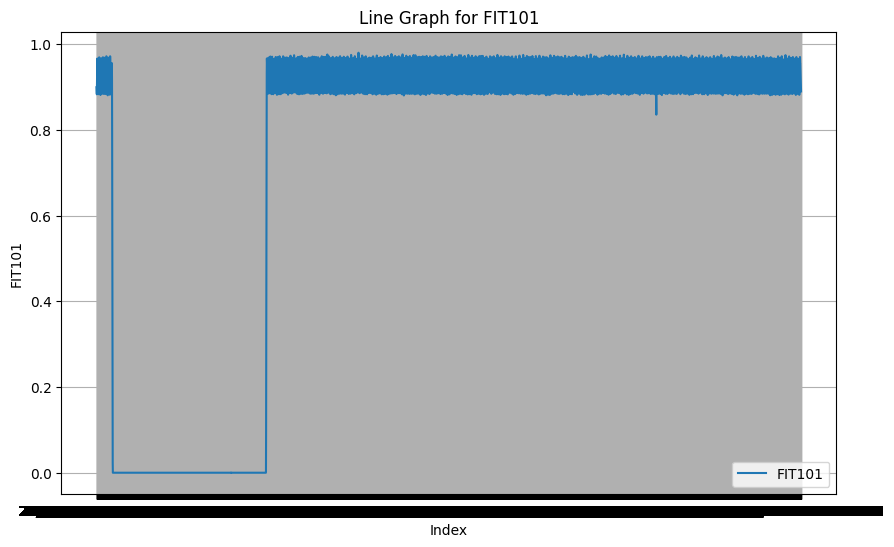

In [58]:
showSensor("FIT101", data, num_values=10000)

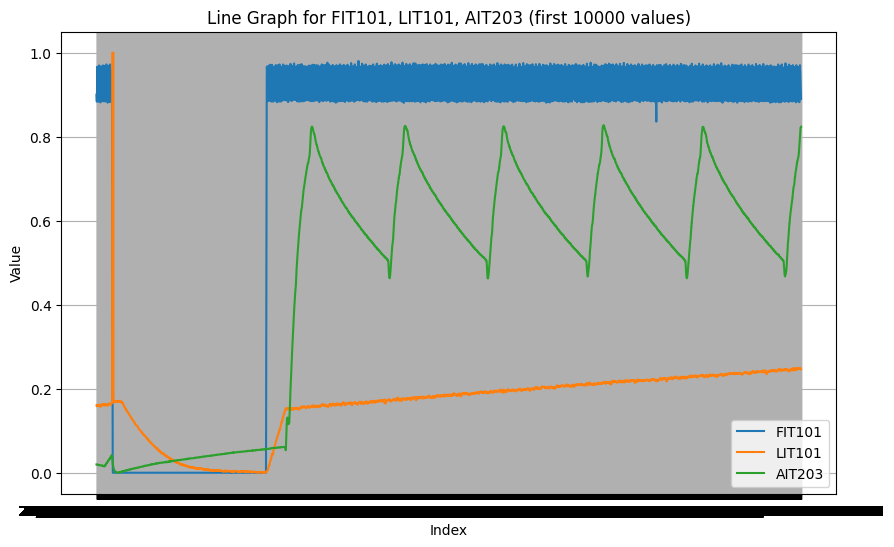

In [64]:
showSensors(["FIT101", "LIT101", "AIT203"], data, num_values=10000)

<h2>Let's start building our model</h2>

In [5]:
window_length=10
feats=103
model = keras.Sequential()
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
model.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
model.compile(loss="mse",optimizer='adam')
model.build()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 10, 64)            43008     
                                                                 
 encoder_2 (LSTM)            (None, 10, 32)            12416     
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 encoder_decoder_bridge (Rep  (None, 10, 16)           0         
 eatVector)                                                      
                                                                 
 decoder_1 (LSTM)            (None, 10, 16)            2112      
                                                                 
 decoder_2 (LSTM)            (None, 10, 32)            6272      
                                                        

In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [63]:
history = model.fit(x=tr_x, y=tr_x, epochs=100, batch_size=16, shuffle=False, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
24840/24840 [==============================] - 1479s 59ms/step - loss: 0.0255 - val_loss: 0.0100
Epoch 2/100
24840/24840 [==============================] - 1536s 62ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 3/100
24840/24840 [==============================] - 1562s 63ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 4/100
24840/24840 [==============================] - 1593s 64ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 5/100
24840/24840 [==============================] - 1744s 70ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/100
24840/24840 [==============================] - 1880s 76ms/step - loss: 0.0018 - val_loss: 0.0010


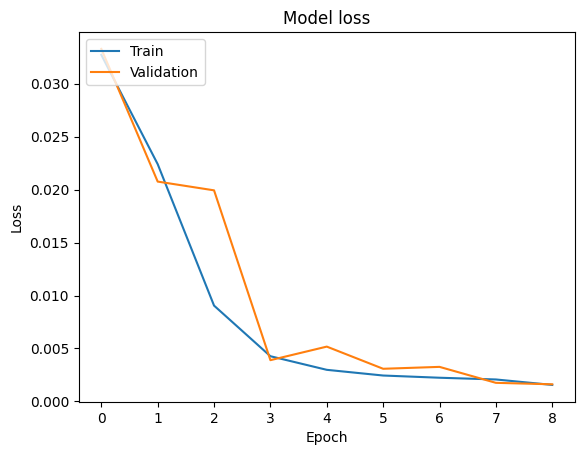

In [15]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [64]:
# Save the weights
#model.save_weights('checkpoints/new_checkpoint1.weights.h5')

In [7]:
#Load the weights 
model.load_weights('checkpoints/new_checkpoint1.weights.h5')

In [10]:
#let us calculate the threshold for the reconsrtuction  error
X_tr_pred = model.predict(tr_x, verbose=0)


In [30]:
# Calculate the mean absolute error for each prediction
calculated_mse = np.mean((X_tr_pred - tr_x) ** 2, axis=(1, 2))

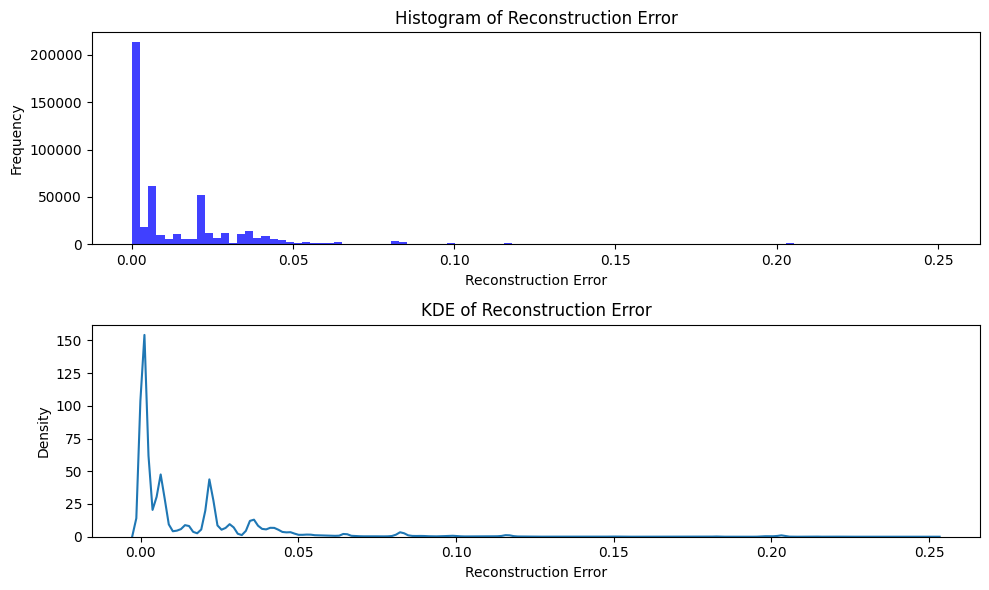

In [32]:
# Plot the distribution of the reconstruction error
plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(2, 1, 1)
plt.hist(calculated_mse, bins=100, alpha=0.75, color='blue')
plt.title('Histogram of Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')

# KDE plot
plt.subplot(2, 1, 2)
sns.kdeplot(calculated_mse, bw_adjust=0.5)
plt.title('KDE of Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [14]:
max = np.max(calculated_mse)
mean = np.mean(calculated_mse)
std_dev = np.std(calculated_mse)
print(f'Maximum Error: {max}')
print(f'Mean is: {mean}')
print(f'mean plus std {mean + 3 * std_dev}')

Maximum Error: 0.25050817320284346
Mean is: 0.016313234972552937
mean plus std 0.09484499169181074


In [16]:
# Calculate the quartiles
Q1 = np.percentile(calculated_mse, 25)
Q2 = np.percentile(calculated_mse, 50)  # This is also the median
Q3 = np.percentile(calculated_mse, 75)

print(f"Q1 (25th percentile): {Q1}")
print(f"Q2 (50th percentile / median): {Q2}")
print(f"Q3 (75th percentile): {Q3}")

Q1 (25th percentile): 0.0009145291829571653
Q2 (50th percentile / median): 0.0059768302411737795
Q3 (75th percentile): 0.022174508672596585


In [17]:
IQR= Q3-Q1
possible_threshold = Q3 + 1.5 * IQR 
print(f'the possible threshold is: {possible_threshold}')
percentile_90 = np.percentile(calculated_mse, 90)
print(percentile_90)

the possible threshold is: 0.054064477907055715
0.04109031645507593


<h1>The Anomaly Detection Part</h1>

In [16]:
mixed_data= "D://Msc_Data_Science_1//Semester 2//Data science lab 1//LSTM data//SWaT_Dataset_Attack_v0 - Copy 2.csv"

In [17]:
scaler= MinMaxScaler()
mixed_data_without_label = dataEngineering(mixed_data, scaler)

C:\Users\mfaki\AppData\Local\Temp\ipykernel_28368\4273617739.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actuators_dummies[actuator]= pd.Categorical(actuators_dummies[actuator], categories=[0, 1, 2])


In [18]:
mixed_data_without_label.shape

(449919, 103)

In [19]:
mixed_data_without_label

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,P502_2,P601_0,P601_1,P601_2,P602_0,P602_1,P602_2,P603_0,P603_1,P603_2
Timestamp,,,,,,,,,,,,,,,,,,,,,
28/12/2015 10:00:00 AM,0.879322,0.452962,0.942783,0.876785,0.436773,0.865044,0.438853,0.928726,0.707350,0.500000,...,0,0,1,0,0,1,0,0,1,0
28/12/2015 10:00:01 AM,0.886285,0.453015,0.942783,0.876785,0.436773,0.865044,0.438853,0.929319,0.707350,0.500000,...,0,0,1,0,0,1,0,0,1,0
28/12/2015 10:00:02 AM,0.901833,0.452962,0.942783,0.876081,0.436773,0.863956,0.437572,0.929480,0.707733,0.500000,...,0,0,1,0,0,1,0,0,1,0
28/12/2015 10:00:03 AM,0.918195,0.453122,0.942783,0.876081,0.436773,0.863956,0.437572,0.929480,0.708116,0.500000,...,0,0,1,0,0,1,0,0,1,0
28/12/2015 10:00:04 AM,0.930842,0.453816,0.942783,0.876081,0.436773,0.864228,0.437572,0.929480,0.708451,0.500000,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/1/2016 2:59:55 PM,0.927477,0.448477,0.000643,0.965415,0.167313,0.870030,0.453294,0.924412,0.729325,0.450104,...,0,0,1,0,0,1,0,0,1,0
2/1/2016 2:59:56 PM,0.923532,0.449652,0.000643,0.965415,0.167313,0.870030,0.453294,0.924412,0.729373,0.450104,...,0,0,1,0,0,1,0,0,1,0
2/1/2016 2:59:57 PM,0.917150,0.450026,0.000643,0.965415,0.167313,0.870257,0.451800,0.923981,0.728990,0.450104,...,0,0,1,0,0,1,0,0,1,0


In [20]:
# mixed_data_without_label.iloc[:-4]

In [21]:
#Function that takes the an the filepath and returns a list of 0 and 1 (normal / attacks)
def labels (filepath):
    df = pd.read_csv(filepath)
    labels= df['Normal/Attack']
    #now let us consider the a ttack and the attack the same (let us replace them by 1)
    #and we will replace the normal with a zero
    labels= labels.replace({'Normal': 0, 'Attack': 1, 'A ttack':1})
    return labels 

In [22]:
labels= labels(mixed_data)

C:\Users\mfaki\AppData\Local\Temp\ipykernel_28368\2199064294.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels= labels.replace({'Normal': 0, 'Attack': 1, 'A ttack':1})


In [23]:
labels

0         0
1         0
2         0
3         0
4         0
         ..
449914    0
449915    0
449916    0
449917    0
449918    0
Name: Normal/Attack, Length: 449919, dtype: int64

In [24]:
len(labels)

449919

previous work  


In [25]:
#let us now recreate the function that also splits the data
def Create_data(data,labels,timestep):
  data= data[:int(len(data)/timestep)*timestep]
  labels= labels[:int(len(labels)/timestep)*timestep]
  anomalies=[]
  x=[]
  _l = len(data)
  for i in range (0, _l, timestep):
    x.append(data[i:i+timestep])
    if((labels.iloc[i:i+timestep]).sum()==0):
      anomalies.append(0)
    else:
      anomalies.append(1)
  p=np.array(x)
  return _l, p,anomalies

In [26]:
l, x, anomalies= Create_data(mixed_data_without_label, labels, 10)

In [27]:
x.shape

(44991, 10, 103)

<h5>saving into pickle files</h5>

In [28]:
import joblib

# Save the NumPy array using joblib
#joblib.dump(x, 'x_mixed.pkl')

['x_mixed.pkl']

In [29]:
# Save the NumPy array using joblib
#joblib.dump(anomalies, 'anomalies_positions.pkl')

['anomalies_positions.pkl']

In [35]:
import joblib

# Load the NumPy array from the file
x = joblib.load('x_mixed.pkl')

anomalies = joblib.load('anomalies_positions.pkl')

In [36]:
predicted_seq= model.predict(x)


1406/1406 [==============================] - 11s 8ms/step


In [37]:
# Calculate the mean absolute error for each prediction
calculated_mse = np.mean((predicted_seq - x) ** 2, axis=(1,2))

In [47]:
# #free up sum space 
# predicted_seq=0
# calculated_mse=0

In [38]:
thresholds = [x / 100.0 for x in range(0, 20)]
for threshold in thresholds:
    detected_anomalies = np.zeros(len(calculated_mse), dtype=int)
    detected_anomalies[calculated_mse > threshold] = 1

    # Calculate tp, tn, fp, fn
    tp, tn, fp, fn = 0, 0, 0, 0
    for i, j in zip(anomalies, detected_anomalies):
        if i == j:
            if i == 0:
                tn += 1
            else:
                tp += 1
        else:
            if i == 0:
                fp += 1
            else:
                fn += 1

    # Calculate precision, recall, and F1-score with checks to avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f'For threshold = {threshold}')
    print(f'tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}')
    print(f'Precision = {precision}')
    print(f'Recall = {recall}')
    print(f'F1-Score = {f1_score}')
    print('----------------------')

For threshold = 0.0
tp: 5493, tn: 0, fp: 39498, fn: 0
Precision = 0.1220910848836434
Recall = 1.0
F1-Score = 0.21761350130734491
----------------------
For threshold = 0.01
tp: 5493, tn: 0, fp: 39498, fn: 0
Precision = 0.1220910848836434
Recall = 1.0
F1-Score = 0.21761350130734491
----------------------
For threshold = 0.02
tp: 4922, tn: 17984, fp: 21514, fn: 571
Precision = 0.18618550461491906
Recall = 0.8960495175678136
F1-Score = 0.30830906072849135
----------------------
For threshold = 0.03
tp: 4613, tn: 22798, fp: 16700, fn: 880
Precision = 0.21644067001360673
Recall = 0.8397961041325324
F1-Score = 0.34417667686338876
----------------------
For threshold = 0.04
tp: 4390, tn: 27936, fp: 11562, fn: 1103
Precision = 0.2752006018054162
Recall = 0.7991989805206626
F1-Score = 0.40941944509209605
----------------------
For threshold = 0.05
tp: 4156, tn: 33499, fp: 5999, fn: 1337
Precision = 0.4092565238798621
Recall = 0.7565993082104496
F1-Score = 0.5311860940695295
--------------------

In [40]:
#let us check the metrics values between 0.15 and 0.17 
thresholds = [round(x, 3) for x in np.arange(0.15, 0.171, 0.001)]
F1_score_max= -1 
tpp, tnp, fpp, fnp=-1,-1,-1,-1
threshold_opt = 1
for threshold in thresholds:
    detected_anomalies = np.zeros(len(calculated_mse), dtype=int)
    detected_anomalies[calculated_mse > threshold] = 1

    # Calculate tp, tn, fp, fn
    tp, tn, fp, fn = 0, 0, 0, 0
    for i, j in zip(anomalies, detected_anomalies):
        if i == j:
            if i == 0:
                tn += 1
            else:
                tp += 1
        else:
            if i == 0:
                fp += 1
            else:
                fn += 1

    # Calculate precision, recall, and F1-score with checks to avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    if (f1_score>F1_score_max):
        F1_score_max=f1_score
        tpp, tnp, fpp, fnp = tp, tn, fp, fn
        threshold_opt=threshold 
print(f'for the threshold {threshold_opt}, the F1 score is {F1_score_max} and tp: {tpp}, tn: {tnp}, fp: {fpp}, fn: {fnp}')

for the threshold 0.156, the F1 score is 0.7361413979111673 and tp: 3207, tn: 39485, fp: 13, fn: 2286


<h1>Incremental learning Part </h1>

In [4]:
filepath = "D://Msc_Data_Science_1//Semester 2//Data science lab 1//LSTM data//SWaT_Dataset_Normal_v0 2.csv"
scaler = MinMaxScaler()
data = dataEngineering(filepath, scaler)

C:\Users\mfaki\AppData\Local\Temp\ipykernel_3756\4273617739.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actuators_dummies[actuator]= pd.Categorical(actuators_dummies[actuator], categories=[0, 1, 2])


In [5]:
def generate_datasets_for_training3(data, window_size):
    _l = len(data)
    Xs = []
    # while (_l % window_size != 0):
    #     _l -= 1
    # data= data.iloc[:(len(data)-_l)]
    for i in range(0, _l- window_size):
        Xs.append(data[i:i+window_size].values) 
        # Convert list to numpy array
    Xs = np.array(Xs)
    
    return (Xs.shape[2], Xs)

In [6]:
feats, XX = generate_datasets_for_training3(data,10)

In [8]:
XX.shape

(496790, 10, 103)

In [16]:
#let us define the splits 
splits = np.array_split(XX,6)

In [17]:
type(splits[0])

numpy.ndarray

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [20]:
train_losses = []
val_losses = []
for i, split in enumerate(splits):
    history = model.fit(x=split, y=split, epochs=100, batch_size=16, shuffle=False, validation_split=0.2, callbacks=[early_stop])
    model.save_weights(f'model_weights_after_split_{i}.h5')
    # Store the losses for this split
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])

Epoch 1/100
4140/4140 [==============================] - 181s 41ms/step - loss: 0.0292 - val_loss: 0.0506
Epoch 2/100
4140/4140 [==============================] - 174s 42ms/step - loss: 0.0302 - val_loss: 0.0496
Epoch 3/100
4140/4140 [==============================] - 168s 40ms/step - loss: 0.0298 - val_loss: 0.0495
Epoch 4/100
4140/4140 [==============================] - 168s 41ms/step - loss: 0.0297 - val_loss: 0.0537
Epoch 5/100
4140/4140 [==============================] - 168s 41ms/step - loss: 0.0205 - val_loss: 0.0257
Epoch 6/100
4140/4140 [==============================] - 169s 41ms/step - loss: 0.0145 - val_loss: 0.0204
Epoch 7/100
4140/4140 [==============================] - 175s 42ms/step - loss: 0.0133 - val_loss: 0.0196
Epoch 8/100
4140/4140 [==============================] - 171s 41ms/step - loss: 0.0119 - val_loss: 0.0197
Epoch 9/100
4140/4140 [==============================] - 173s 42ms/step - loss: 0.0132 - val_loss: 0.0198
Epoch 10/100
4140/4140 [======================

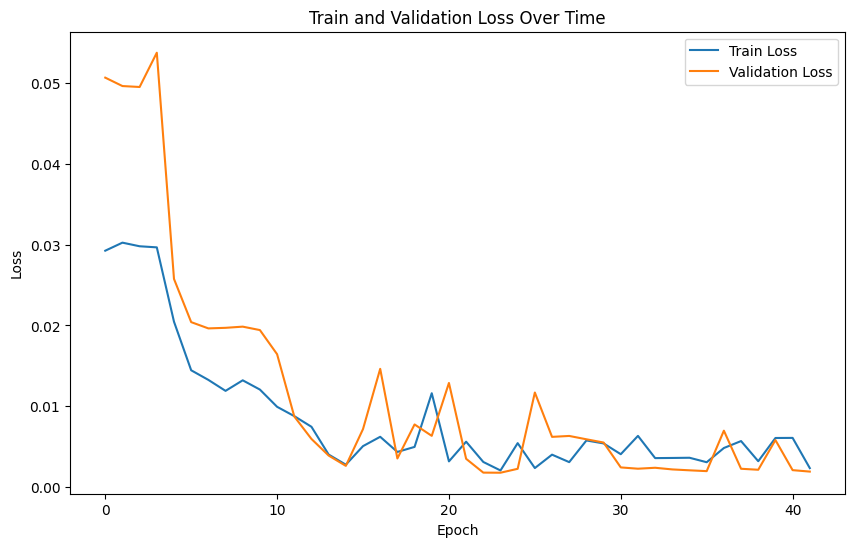

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Over Time')
plt.legend()
plt.show()

In [42]:
model.load_weights('model_weights_after_split_5.h5')

In [45]:
#now let us find a threshold 

_predicts  = model.predict(tr_x, verbose=0)

In [48]:
test_mse_loss = np.mean((_predicts -tr_x) ** 2, axis=(1,2))

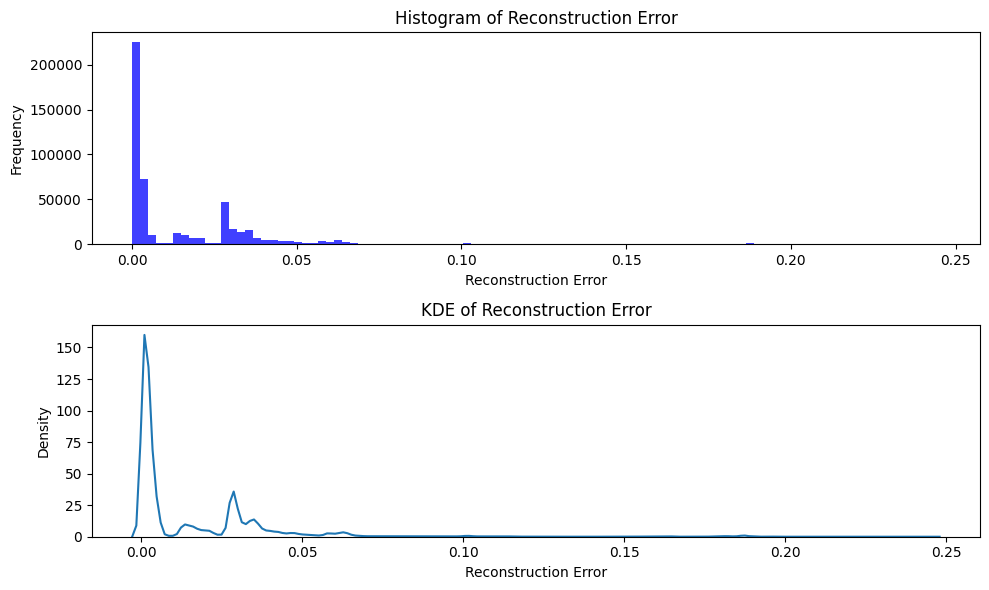

In [49]:
# Plot the distribution of the reconstruction error
plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(2, 1, 1)
plt.hist(test_mse_loss, bins=100, alpha=0.75, color='blue')
plt.title('Histogram of Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')

# KDE plot
plt.subplot(2, 1, 2)
sns.kdeplot(test_mse_loss, bw_adjust=0.5)
plt.title('KDE of Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [50]:
max = np.max(test_mse_loss)
mean = np.mean(test_mse_loss)
std_dev = np.std(test_mse_loss)
print(f'Maximum Error: {max}')
print(f'Mean is: {mean}')
print(f'mean plus std {mean + 3 * std_dev}')

Maximum Error: 0.2451706477128896
Mean is: 0.01580863369000318
mean plus std 0.09274889319995885


In [51]:
# Calculate the quartiles
Q1 = np.percentile(test_mse_loss, 25)
Q2 = np.percentile(test_mse_loss, 50)  # This is also the median
Q3 = np.percentile(test_mse_loss, 75)

print(f"Q1 (25th percentile): {Q1}")
print(f"Q2 (50th percentile / median): {Q2}")
print(f"Q3 (75th percentile): {Q3}")

Q1 (25th percentile): 0.0012507011380163257
Q2 (50th percentile / median): 0.0029045964126883646
Q3 (75th percentile): 0.0282974601557989


In [52]:
IQR= Q3-Q1
possible_threshold = Q3 + 1.5 * IQR 
print(f'the possible threshold is: {possible_threshold}')

the possible threshold is: 0.06886759868247276


In [53]:
percentile_90 = np.percentile(test_mse_loss, 90)
print(percentile_90)

0.03835019844933121


In [54]:
############################

In [ ]:
############################

<h1>Now let us check the anomaly detection part</h1>

In [57]:
import joblib

# Load the NumPy array from the file
x = joblib.load('x_mixed.pkl')

anomalies = joblib.load('anomalies_positions.pkl')

In [58]:
predicted_seq= model.predict(x)

1406/1406 [==============================] - 13s 9ms/step


In [59]:
test_mse_loss = np.mean((predicted_seq -x) ** 2, axis=(1,2))

In [60]:
thresholds = [x / 100.0 for x in range(0, 20)]
for threshold in thresholds:
    detected_anomalies = np.zeros(len(test_mse_loss), dtype=int)
    detected_anomalies[test_mse_loss > threshold] = 1

    # Calculate tp, tn, fp, fn
    tp, tn, fp, fn = 0, 0, 0, 0
    for i, j in zip(anomalies, detected_anomalies):
        if i == j:
            if i == 0:
                tn += 1
            else:
                tp += 1
        else:
            if i == 0:
                fp += 1
            else:
                fn += 1

    # Calculate precision, recall, and F1-score with checks to avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f'For threshold = {threshold}')
    print(f'tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}')
    print(f'Precision = {precision}')
    print(f'Recall = {recall}')
    print(f'F1-Score = {f1_score}')
    print('----------------------')

For threshold = 0.0
tp: 5493, tn: 0, fp: 39498, fn: 0
Precision = 0.1220910848836434
Recall = 1.0
F1-Score = 0.21761350130734491
----------------------
For threshold = 0.01
tp: 5493, tn: 68, fp: 39430, fn: 0
Precision = 0.1222758943080382
Recall = 1.0
F1-Score = 0.21790701364646145
----------------------
For threshold = 0.02
tp: 4822, tn: 22336, fp: 17162, fn: 671
Precision = 0.21934133915574963
Recall = 0.8778445294010558
F1-Score = 0.350984459729956
----------------------
For threshold = 0.03
tp: 4568, tn: 23452, fp: 16046, fn: 925
Precision = 0.22159697293101777
Recall = 0.8316038594574914
F1-Score = 0.3499444593404068
----------------------
For threshold = 0.04
tp: 4267, tn: 26957, fp: 12541, fn: 1226
Precision = 0.253867206092337
Recall = 0.7768068450755508
F1-Score = 0.3826734227164701
----------------------
For threshold = 0.05
tp: 4082, tn: 32965, fp: 6533, fn: 1411
Precision = 0.3845501648610457
Recall = 0.743127616967049
F1-Score = 0.5068289048919791
----------------------
Fo

In [63]:
#let us check the highest f1 score assuming it is between 0.17 and 0.19 
#let us check the metrics values between 0.15 and 0.17 
thresholds = [round(x, 3) for x in np.arange(0.17, 0.19, 0.001)]
F1_score_max= -1 
tpp, tnp, fpp, fnp=-1,-1,-1,-1
threshold_opt = 1
for threshold in thresholds:
    detected_anomalies = np.zeros(len(test_mse_loss), dtype=int)
    detected_anomalies[test_mse_loss > threshold] = 1

    # Calculate tp, tn, fp, fn
    tp, tn, fp, fn = 0, 0, 0, 0
    for i, j in zip(anomalies, detected_anomalies):
        if i == j:
            if i == 0:
                tn += 1
            else:
                tp += 1
        else:
            if i == 0:
                fp += 1
            else:
                fn += 1

    # Calculate precision, recall, and F1-score with checks to avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    if (f1_score>F1_score_max):
        F1_score_max=f1_score
        tpp, tnp, fpp, fnp = tp, tn, fp, fn
        threshold_opt=threshold 
print(f'for the threshold {threshold_opt}, the F1 score is {F1_score_max} and tp: {tpp}, tn: {tnp}, fp: {fpp}, fn: {fnp}')

for the threshold 0.183, the F1 score is 0.737047673750718 and tp: 3208, tn: 39494, fp: 4, fn: 2285
